In [1]:
## collect Class A RIFINs
## These are RIFINs that have a 25-aa conserved insertion after the first conserved domain C1 
## I downloaded all RIFINs used in our library, did a MSA and identified the Class A ones 

fh = open('RIFIN_ClassA.txt','r')
rifin_classa = set()
for line in fh: 
    gene = line.split(' ')[0]
    rifin_classa.add(gene)
    
fh.close()

len(rifin_classa)

62

In [99]:
## List of all rifin proteins in 3D7 and IT - collect seq as dictionary 

fh = open('PlasmoDB-33_Pfalciparum3D7_AnnotatedProteins.known.A.fasta','r')

rifin_seq = {}

for line in fh: 
    if line[0] == '>':
          if ('Rifin' in line) or ('RIFIN' in line) or ('rifin' in line): 
            gene = line[1:].strip('\n').replace('|',':')
            gene = gene.replace(',','_')
            gene = gene.split('.')[0].strip(' ')
            rifin_seq[gene]= next(fh).strip('\n')
fh.close()
print (len(rifin_seq))
fh = open('PlasmoDB-33_PfalciparumIT_AnnotatedProteins.known.A.fasta','r')


for line in fh: 
    if line[0] == '>':
          if ('Rifin' in line) or ('RIFIN' in line) or ('rifin' in line): 
            gene = line[1:].strip('\n').replace('|',':')
            gene = gene.replace(',','_')
            gene = gene.split('.')[0].strip(' ')
            rifin_seq[gene]= next(fh).strip('\n')
fh.close()
len(rifin_seq)
    


157


275

In [100]:
# Collect all hit RIFIN 3D7 peptides in the dataset 


import re 
f = open('HITS_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil_allhits_sequences_9227.fa','r')

### forming a new one bec of incompatability with the ID of the whole set 
rifin_hits = {} ## tuple of (gene name, product,sequence) 

i = 0
for line in f: 
    name = line.lstrip(">")
    name = name.strip("\n")
    name = name.replace('|',':')
   
    if re.search(r'rifin|RIFIN|Rifin',name):
        if ('PF3D7' in name) | ('PFIT' in name):
            gene = name.split(":")[0] 
            product = 'rifin'

    
            rifin_hits[name] = (next(f).strip('\n'))
       
    i = i+1
f.close()


len(rifin_hits)

279

In [101]:
## For each RIFIN peptide, identify all the RIFIN proteins and the positions that it aligns to 

from collections import defaultdict 
rifin_peptides_all_proteins = defaultdict(set)

for pep in rifin_hits: 
    seq = rifin_hits[pep]
    
    rifin_peptides_all_proteins[pep] = set([(rifinprtn.strip('\n')+'|'+ str(prtnseq.find(seq))) for rifinprtn,prtnseq in rifin_seq.items() if (seq in prtnseq) ])
    


In [102]:
import pandas as pd 

df_meta = pd.read_excel("Ugandan_samples_metadata.xlsx",header=0,index_col = 'Barcode',engine='openpyxl') ##sample name is the index


df_hits = pd.read_csv('HITS_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil.csv',header=0,index_col=0)
df_hits = df_hits.filter(regex='CK3|CT3',axis=1)

df_hits_meta_combined = pd.merge(df_hits.T, df_meta, left_index=True, right_index=True)

def childadult(row):
    age = row.age
    
    if (age >=7) & (age <= 11):
        status = 'child_7_11'
        
    elif (age >= 2) & (age < 4):
        status = 'child_2_4'
   
    elif (age >= 4) & (age < 7):
        status = 'child_4_7'
        
    else:
        status = 'adult'
    
    return status
    
def agecut(row):
    age = row.age
    
    if (age >= 2) & (age < 4):
        agecut = '2-4'
        
    elif (age >= 4) & (age < 7):
        agecut = '4-7'
    elif (age >= 7) & (age < 11):
        agecut = '7-11'
    else:
        agecut = '>18'
    return agecut

df_hits_meta_combined['status'] = df_hits_meta_combined.apply(childadult,axis=1)
df_hits_meta_combined['agecut'] = df_hits_meta_combined.apply(agecut,axis=1)


child_2_4_eir = df_hits_meta_combined[df_hits_meta_combined['status'] == 'child_2_4'].eir_geom3
# print "EIR quantiles for children, min, 33%, 50%, 66%, max \n"
# print child_eir.quantile(q=0).round(2),child_eir.quantile(q=0.33).round(2),child_eir.quantile(q=0.5).round(2),child_eir.quantile(q=0.66).round(2),child_eir.quantile(q=1).round(2),"\n"
child_4_7_eir = df_hits_meta_combined[df_hits_meta_combined['status'] == 'child_4_7'].eir_geom3
child_7_11_eir = df_hits_meta_combined[df_hits_meta_combined['status'] == 'child_7_11'].eir_geom3

adult_eir = df_hits_meta_combined[df_hits_meta_combined['status'] == 'adult'].eir_geom3
# print "\n EIR quantiles for adults, min, 33%, 50%, 66%, max \n"
# print adult_eir.quantile(q=0).round(2),adult_eir.quantile(q=0.33).round(2),adult_eir.quantile(q=0.5).round(2),adult_eir.quantile(q=0.66).round(2),adult_eir.quantile(q=1).round(2),"\n"


def eircut(row):
    eir = row.eir_geom3
    status = row.status
    
    if status == 'child_2_4':
        eir_50percent = child_2_4_eir.quantile(q=0.5)
        
    elif status == 'child_4_7':
        eir_50percent = child_4_7_eir.quantile(q=0.5)
        
    elif status == 'child_7_11':
        eir_50percent = child_7_11_eir.quantile(q=0.5)
                      
    elif status == 'adult':
        eir_50percent = adult_eir.quantile(q=0.5)
        
    
                 
    if eir <= eir_50percent:
        eir_cut = 'low'
        return eir_cut
                    
    else:
        eir_cut = 'high'
        return eir_cut
        
df_hits_meta_combined['eircut'] = df_hits_meta_combined.apply(eircut,axis=1)


In [103]:
## Identify overall breadth 


## GO  THROUGH EACh sample and get the list of rifin peptides hit in that sample 
## Collect the set of proteins all of these peptides refer to
## This gives the overall breadth of riifin prpoteins reacted to in that sample 
 

samples = list(df_hits.iloc[:,:199])

for person in samples:
    person_rifin_set = set()
    temp = df_hits[df_hits[person]==1]
    
    for pep in temp.index:
        pep = pep.replace('|',':')
        if pep in rifin_peptides_all_proteins:
            rifin_proteins = rifin_peptides_all_proteins[pep]
            person_rifin_set.update(rifin_proteins)
        
    
    
    df_hits_meta_combined.loc[person,'total'] = len( person_rifin_set) 
     

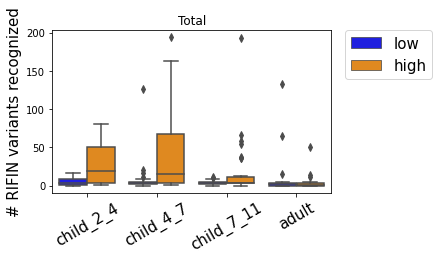

In [107]:
fig, ax = plt.subplots(figsize=(5,3))
palette = {'high':'darkorange','low':'blue'}

sns.boxplot(x="status", y="total", data=df_hits_meta_combined , order = ['child_2_4','child_4_7','child_7_11','adult'],  dodge=True,hue= 'eircut',hue_order=['low','high'],ax=ax,palette=palette,
            ).set_title('Total')
#sns.stripplot(x="status", y="total", data=df_hits_meta_combined , order = ['child_2_4','child_4_7','child_7_11','adult'],  dodge=True,hue= 'eircut',hue_order=['low','high'],ax=ax).set_title('C1 domain')
#ax.set_ylim(0,120)
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15,rotation = 30)
#ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 15)
plt.xlabel('')
plt.ylabel('# RIFIN variants recognized',fontsize = 15)

plt.savefig('Fig_2d_RIFIN_overallbreadth.pdf',dpi=800,bbox_inches='tight')
plt.show()


In [108]:
a = df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_2_4')&(df_hits_meta_combined['eircut'] =='low')]['total']
b = df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_4_7')&(df_hits_meta_combined['eircut'] =='low')]['total']
c =df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_7_11')&(df_hits_meta_combined['eircut'] =='low')]['total']
d =df_hits_meta_combined[(df_hits_meta_combined['status'] =='adult')&(df_hits_meta_combined['eircut'] =='low')]['total']

e=df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_2_4')&(df_hits_meta_combined['eircut'] =='high')]['total']
f=df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_4_7')&(df_hits_meta_combined['eircut'] =='high')]['total']
g=df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_7_11')&(df_hits_meta_combined['eircut'] =='high')]['total']
h=df_hits_meta_combined[(df_hits_meta_combined['status'] =='adult')&(df_hits_meta_combined['eircut'] =='high')]['total']

from scipy import stats 

print (stats.ks_2samp(a,d))
print (stats.ks_2samp(b,d))
print (stats.ks_2samp(c,d))
print (stats.ks_2samp(b,c))

print (stats.ks_2samp(e,h))
print (stats.ks_2samp(f,h))
print (stats.ks_2samp(g,h))
print (stats.ks_2samp(f,g))

print (a.median())
print (b.median())
print (c.median())
print (d.median())
print (e.median())
print (f.median())
print (g.median())
print (h.median())

KstestResult(statistic=0.3, pvalue=0.47511239546593576)
KstestResult(statistic=0.2, pvalue=0.5940706297759378)
KstestResult(statistic=0.23333333333333334, pvalue=0.39294501397971776)
KstestResult(statistic=0.1, pvalue=0.9988393756362763)
KstestResult(statistic=0.6130268199233716, pvalue=0.00604247647591305)
KstestResult(statistic=0.5988505747126437, pvalue=1.0259590812355945e-05)
KstestResult(statistic=0.41954022988505746, pvalue=0.008527266294726221)
KstestResult(statistic=0.4, pvalue=0.015643390496754332)
4.0
3.0
3.0
2.0
19.0
15.5
4.0
1.0


In [110]:
### Then for the RIFIN hit peptides, assign domains to them based on wheere they are aligninging in the correspnding RIFIN proteins 

## USE this template to assign domains 

### Mapped the positions of the different regions in RIFINs based on MSA and this papeer -Sub-grouping and sub-functionalization of the RIFIN multi-copy protein family
## Use only PF3D7 proteins 
# Signal peptide - 1- ~20aa
# Variable region V1 - ~20 - ~45
#PEXEL motif = 45-50aa
# Conserved region C1 - 51-~110
# Extra 25aa conserved sequence in Class A RIFINs - 110-135
# Transmembrane domain TM 1 - Ends in 170aa for Class A RIFINs and 140aa for others 
# Variable region V2 - After TM1 
# TM2 + Conserved region C2 - last 45aa (~25 + 20)

## So, for non-Class A RIFINs, Peptides 3 and 4 represent C1 and TM1
## For class A RIFINs, Peptides 3,4,5 represent C1 and TM1 
## For both classes, Peptide 2 represents half V1 and half C1. so, if peptide 1 from that protein is also enriched, then it most likely reactes to V1, if not it most likely is C1  
# Peptides >= 5 for non-Class A and >=6 for non-class A except for the last peptide represent V2 


rifin_peptides_all_proteins_withdomains = defaultdict(set)

for pep,val in rifin_peptides_all_proteins.items():
    for z in val: ## going through each protein match for the peptide
      
        gene = z.split('|')[0].strip(' ')
        start = int(z.split('|')[-1])
        end = start + 61 
        seqaa = set(range(start,end))
        
        if gene not in rifin_classa: ## for non-class A RIFINs, the domain positions are diifferent
            rifin_domains = {(20,45):'V1',(50,100):'C1',(100,140):'TM1',(140,len(rifin_seq[gene])-45):'V2',(len(rifin_seq[gene])-45,len(rifin_seq[gene])):'C2'}
            for x in rifin_domains:
                domain = rifin_domains[x]
                start,end = int(x[0]),int(x[1])
                domaa = set(range(start,end))
                overlap = len(seqaa.intersection(domaa))
                if overlap >= 20:
                    rifin_peptides_all_proteins_withdomains[pep].add(gene+'_'+domain)
                                                                   
        

        elif gene in rifin_classa: ## for class A RIFINs, the domain positions are diifferent
            rifin_domains = {(20,45):'V1',(50,100):'C1',(100,170):'TM1',(170,len(rifin_seq[gene])-45):'V2',(len(rifin_seq[gene])-45,len(rifin_seq[gene])):'C2'}
            for x in rifin_domains:
                domain = rifin_domains[x]
                start,end = int(x[0]),int(x[1])
                domaa = set(range(start,end))
                overlap = len(seqaa.intersection(domaa))
                if overlap >= 20:
                    rifin_peptides_all_proteins_withdomains[pep].add(gene+'_'+domain)
                                                                   

In [111]:
### Calculate breadth of reactivity to different rifin domains per person 

## GO  THROUGH EACh sample and get the list of rifin peptides hit in that sample 
## Collect the set of proteins all of these peptides refer to
## This gives the overall breadth of riifin prpoteins reacted to in that sample 
 
### Calculate breadth of reactivity to different rifin domains per person 


samples = list(df_hits.iloc[:,:199])

for person in samples:
    person_rifin_set = set()
    temp = df_hits[df_hits[person]==1]
    
    for pep in temp.index:
        pep = pep.replace('|',':')
        if pep in rifin_peptides_all_proteins_withdomains:
            rifin_proteins = rifin_peptides_all_proteins_withdomains[pep]
            person_rifin_set.update(rifin_proteins)
        
    
    
    df_hits_meta_combined.loc[person,'V1'] = len([s for s in person_rifin_set if "V1" in s]) 
    df_hits_meta_combined.loc[person,'V2'] = len([s for s in person_rifin_set if "V2" in s]) 
   
    df_hits_meta_combined.loc[person,'C1'] = len([s for s in person_rifin_set if "C1" in s]) 
    df_hits_meta_combined.loc[person,'C2'] = len([s for s in person_rifin_set if "C2" in s]) 
    

In [112]:
person_rifin_set

{'PF3D7_0100200_C1',
 'PF3D7_0101000_C1',
 'PF3D7_0101000_TM1',
 'PF3D7_0115200_C1',
 'PF3D7_0115200_TM1',
 'PF3D7_0115600_C1',
 'PF3D7_0115600_TM1',
 'PF3D7_0200200_C1',
 'PF3D7_0200200_TM1',
 'PF3D7_0200700_C1',
 'PF3D7_0200700_TM1',
 'PF3D7_0222600_C1',
 'PF3D7_0222600_TM1',
 'PF3D7_0222600_V2',
 'PF3D7_0324400_C1',
 'PF3D7_0324400_TM1',
 'PF3D7_0400300_C1',
 'PF3D7_0600300_C1',
 'PF3D7_0600300_TM1',
 'PF3D7_0632000_C1',
 'PF3D7_0700200_V2',
 'PF3D7_0732400_V2',
 'PF3D7_0732500_C1',
 'PF3D7_0732500_TM1',
 'PF3D7_0800500_C1',
 'PF3D7_0800500_TM1',
 'PF3D7_0800500_V2',
 'PF3D7_0833000_C1',
 'PF3D7_0833000_TM1',
 'PF3D7_0833100_C1',
 'PF3D7_0937500_C1',
 'PF3D7_0937700_V2',
 'PF3D7_1040500_C1',
 'PF3D7_1040500_TM1',
 'PF3D7_1040700_C1',
 'PF3D7_1041200_C1',
 'PF3D7_1041200_TM1',
 'PF3D7_1100300_C1',
 'PF3D7_1100300_TM1',
 'PF3D7_1101100_C1',
 'PF3D7_1101100_TM1',
 'PF3D7_1101300_V2',
 'PF3D7_1300700_C1',
 'PF3D7_1300700_TM1',
 'PF3D7_1479700_C1',
 'PF3D7_1479700_TM1',
 'PF3D7_1479800_T

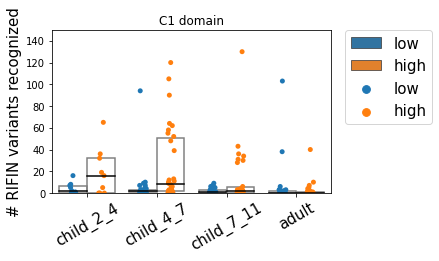

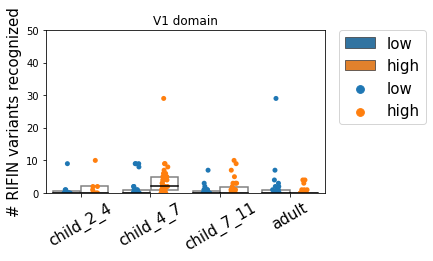

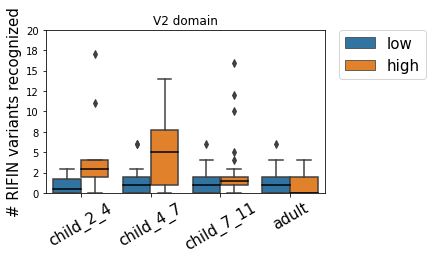

In [119]:

fig, ax = plt.subplots(figsize=(5,3))

sns.boxplot(medianprops={'visible': True,'color':'black'},
            whiskerprops={'visible': False},
            zorder=10,x="status", y="C1", data=df_hits_meta_combined , order = ['child_2_4','child_4_7','child_7_11','adult'],  dodge=True,hue= 'eircut',hue_order=['low','high'],ax=ax,
           showfliers=False,
            showbox=True,
            showcaps=False,
            boxprops={'facecolor':'none', 'edgecolor':'grey'},
            ).set_title('C1 domain')
sns.stripplot(x="status", y="C1", data=df_hits_meta_combined , order = ['child_2_4','child_4_7','child_7_11','adult'],  dodge=True,hue= 'eircut',hue_order=['low','high'],ax=ax).set_title('C1 domain')
ax.set_ylim(0,150)
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15,rotation = 30)
#ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 15)
plt.xlabel('')
plt.ylabel('# RIFIN variants recognized',fontsize = 15)

plt.savefig('Fig_Temp4_RIFIN_domain_C1.pdf',dpi=800)
plt.show()

fig, ax = plt.subplots(figsize=(5,3))

sns.boxplot(medianprops={'visible': True,'color':'black'},
            whiskerprops={'visible': False},
            zorder=10,x="status", y="V1", data=df_hits_meta_combined , order = ['child_2_4','child_4_7','child_7_11','adult'],  dodge=True,hue= 'eircut',hue_order=['low','high'],ax=ax,
           showfliers=False,
            showbox=True,
            showcaps=False,
            boxprops={'facecolor':'none', 'edgecolor':'grey'},
            ).set_title('V1 domain')
sns.stripplot(x="status", y="V1", data=df_hits_meta_combined , order = ['child_2_4','child_4_7','child_7_11','adult'],  dodge=True,hue= 'eircut',hue_order=['low','high'],ax=ax).set_title('V1 domain')

# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15,rotation = 30)
#ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 15)
ax.set_xlabel('')
ax.set_ylabel('# RIFIN variants recognized',fontsize = 15)
ax.set_ylim(0,50)
#

plt.savefig('Fig_Temp4_RIFIN_domain_V1.pdf',dpi=800)


fig, ax = plt.subplots(figsize=(5,3))

# sns.boxplot(medianprops={'visible': True,'color':'black'},
#             whiskerprops={'visible': False},
#             zorder=10,x="status", y="V2", data=df_hits_meta_combined , order = ['child_2_4','child_4_7','child_7_11','adult'],  dodge=True,hue= 'eircut',hue_order=['low','high'],ax=ax,
#            showfliers=False,
#             showbox=True,
#             showcaps=False,
#             boxprops={'facecolor':'none', 'edgecolor':'grey'},
#             ).set_title('V2 domain')
# sns.stripplot(x="status", y="V2", data=df_hits_meta_combined , order = ['child_2_4','child_4_7','child_7_11','adult'],  dodge=True,hue= 'eircut',hue_order=['low','high'],ax=ax).set_title('V2 domain')
sns.boxplot(medianprops={'visible': True,'color':'black'},
            x="status", y="V2", data=df_hits_meta_combined , order = ['child_2_4','child_4_7','child_7_11','adult'],  dodge=True,hue= 'eircut',hue_order=['low','high'],ax=ax,
         ).set_title('V2 domain')


ax.set_ylim(0,20)
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15,rotation = 30)
#ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 15)
ax.set_xlabel('')
ax.set_ylabel('# RIFIN variants recognized',fontsize = 15)

plt.savefig('Fig_Temp4_RIFIN_domain_V2.pdf',dpi=800)
plt.show()



In [53]:
a = df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_2_4')&(df_hits_meta_combined['eircut'] =='low')]['C1']
b = df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_4_7')&(df_hits_meta_combined['eircut'] =='low')]['C1']
c =df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_7_11')&(df_hits_meta_combined['eircut'] =='low')]['C1']
d =df_hits_meta_combined[(df_hits_meta_combined['status'] =='adult')&(df_hits_meta_combined['eircut'] =='low')]['C1']

e=df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_2_4')&(df_hits_meta_combined['eircut'] =='high')]['C1']
f=df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_4_7')&(df_hits_meta_combined['eircut'] =='high')]['C1']
g=df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_7_11')&(df_hits_meta_combined['eircut'] =='high')]['C1']
h=df_hits_meta_combined[(df_hits_meta_combined['status'] =='adult')&(df_hits_meta_combined['eircut'] =='high')]['C1']

from scipy import stats 

print (stats.ks_2samp(a,d))
print (stats.ks_2samp(b,d))
print (stats.ks_2samp(c,d))
print (stats.ks_2samp(b,c))

print (stats.ks_2samp(e,h))
print (stats.ks_2samp(f,h))
print (stats.ks_2samp(g,h))
print (stats.ks_2samp(f,g))

print (a.median())
print (b.median())
print (c.median())
print (d.median())
print (e.median())
print (f.median())
print (g.median())
print (h.median())

KstestResult(statistic=0.2, pvalue=0.9079505846708483)
KstestResult(statistic=0.2, pvalue=0.5940706297759378)
KstestResult(statistic=0.16666666666666666, pvalue=0.8079631540901643)
KstestResult(statistic=0.06666666666666667, pvalue=0.9999999909208507)
KstestResult(statistic=0.5977011494252874, pvalue=0.007926157911177567)
KstestResult(statistic=0.5275862068965518, pvalue=0.00023511086860095176)
KstestResult(statistic=0.3275862068965517, pvalue=0.056500474653251365)
KstestResult(statistic=0.3, pvalue=0.13500350250095441)
0.5
1.0
1.0
0.0
10.0
6.0
1.5
0.0


In [54]:
a = df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_2_4')&(df_hits_meta_combined['eircut'] =='low')]['V2']
b = df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_4_7')&(df_hits_meta_combined['eircut'] =='low')]['V2']
c =df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_7_11')&(df_hits_meta_combined['eircut'] =='low')]['V2']
d =df_hits_meta_combined[(df_hits_meta_combined['status'] =='adult')&(df_hits_meta_combined['eircut'] =='low')]['V2']

e=df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_2_4')&(df_hits_meta_combined['eircut'] =='high')]['V2']
f=df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_4_7')&(df_hits_meta_combined['eircut'] =='high')]['V2']
g=df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_7_11')&(df_hits_meta_combined['eircut'] =='high')]['V2']
h=df_hits_meta_combined[(df_hits_meta_combined['status'] =='adult')&(df_hits_meta_combined['eircut'] =='high')]['V2']

from scipy import stats 

print (stats.ks_2samp(a,d))
print (stats.ks_2samp(b,d))
print (stats.ks_2samp(c,d))
print (stats.ks_2samp(b,c))

print (stats.ks_2samp(e,h))
print (stats.ks_2samp(f,h))
print (stats.ks_2samp(g,h))
print (stats.ks_2samp(f,g))

print (a.median())
print (b.median())
print (c.median())
print (d.median())
print (e.median())
print (f.median())
print (g.median())
print (h.median())

KstestResult(statistic=0.2, pvalue=0.9079505846708483)
KstestResult(statistic=0.03333333333333333, pvalue=1.0)
KstestResult(statistic=0.1, pvalue=0.9988393756362763)
KstestResult(statistic=0.06666666666666667, pvalue=0.9999999909208507)
KstestResult(statistic=0.5095785440613027, pvalue=0.036784612436265185)
KstestResult(statistic=0.5, pvalue=0.0004536769311396238)
KstestResult(statistic=0.32068965517241377, pvalue=0.07594816080171707)
KstestResult(statistic=0.3, pvalue=0.13500350250095441)
0.0
0.0
0.0
0.0
2.0
2.5
1.0
0.0


In [55]:
a = df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_2_4')&(df_hits_meta_combined['eircut'] =='low')]['V1']
b = df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_4_7')&(df_hits_meta_combined['eircut'] =='low')]['V1']
c =df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_7_11')&(df_hits_meta_combined['eircut'] =='low')]['V1']
d =df_hits_meta_combined[(df_hits_meta_combined['status'] =='adult')&(df_hits_meta_combined['eircut'] =='low')]['V1']

e=df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_2_4')&(df_hits_meta_combined['eircut'] =='high')]['V1']
f=df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_4_7')&(df_hits_meta_combined['eircut'] =='high')]['V1']
g=df_hits_meta_combined[(df_hits_meta_combined['status'] =='child_7_11')&(df_hits_meta_combined['eircut'] =='high')]['V1']
h=df_hits_meta_combined[(df_hits_meta_combined['status'] =='adult')&(df_hits_meta_combined['eircut'] =='high')]['V1']

from scipy import stats 

print (stats.ks_2samp(a,d))
print (stats.ks_2samp(b,d))
print (stats.ks_2samp(c,d))
print (stats.ks_2samp(b,c))

print (stats.ks_2samp(e,h))
print (stats.ks_2samp(f,h))
print (stats.ks_2samp(g,h))
print (stats.ks_2samp(f,g))

print (a.median())
print (b.median())
print (c.median())
print (d.median())
print (e.median())
print (f.median())
print (g.median())
print (h.median())

KstestResult(statistic=0.16666666666666666, pvalue=0.9797932999895449)
KstestResult(statistic=0.1, pvalue=0.9988393756362763)
KstestResult(statistic=0.13333333333333333, pvalue=0.9578462903438838)
KstestResult(statistic=0.06666666666666667, pvalue=0.9999999909208507)
KstestResult(statistic=0.1111111111111111, pvalue=0.9998390053618257)
KstestResult(statistic=0.3954022988505747, pvalue=0.011182294432554807)
KstestResult(statistic=0.19540229885057472, pvalue=0.5211618314356481)
KstestResult(statistic=0.2, pvalue=0.5940706297759378)
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
